In [148]:
import pandas as pd
pd.options.display.max_columns = 100
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import gc

train_df = pd.read_csv('../input/train.csv')
test_df = pd.read_csv('../input/test.csv')
sample_submit = pd.read_csv('../input/sample_submit.csv', header=None, names=['id', 'y'])
print('train :', len(train_df))
print('test: ', len(test_df))
print('sample_submit :', len(sample_submit))

train : 55583
test:  18528
sample_submit : 18528


In [145]:
train=train_df.copy()
train = train.drop(['id','y'], axis=1)
train.groupby('bedrooms').agg(['count', 'mean', 'sum']).reset_index()

bedrooms     id                           accommodates                    \
             count          mean         sum        count       mean    sum   
0       0.0   5016  27717.731858   139032143         5016   2.542464  12753   
1       1.0  37338  27754.353313  1036292044        37338   2.324334  86786   
2       2.0   8575  27878.394286   239057231         8575   4.769446  40898   
3       3.0   3195  28057.923631    89645066         3195   6.702973  21416   
4       4.0    994  28105.484909    27936852          994   8.688129   8636   
5       5.0    267  27684.183521     7391677          267  10.700375   2857   
6       6.0     78  24579.384615     1917192           78  12.833333   1001   
7       7.0     26  23446.923077      609620           26  14.884615    387   
8       8.0     10  29857.800000      298578           10  15.400000    154   
9       9.0      4  21737.750000       86951            4  16.000000     64   
10     10.0      9  29556.444444      266008            9  14.444444    130   

   bathrooms                      beds                     latitude  \
       count      mean      sum  count       mean      sum    count   
0       5016  1.010865   5070.5   5013   1.269499   6364.0     5016   
1      37208  1.101121  40970.5  37273   1.276339  47573.0    37338   
2       8566  1.414371  12115.5   8571   2.490841  21349.0     8575   
3       3193  1.947698   6219.0   3195   3.724570  11900.0     3195   
4        992  2.646169   2625.0    992   4.901210   4862.0      994   
5        267  3.426966    915.0    267   6.438202   1719.0      267   
6         78  4.044872    315.5     78   7.525641    587.0       78   
7         26  4.923077    128.0     26   9.923077    258.0       26   
8         10  4.950000     49.5     10  12.200000    122.0       10   
9          4  3.500000     14.0      4  14.250000     57.0        4   
10         9  5.777778     52.0      9  14.000000    126.0        9   

                            longitude                            \
         mean           sum     count        mean           sum   
0   38.311516  1.921706e+05      5016  -92.853231 -4.657518e+05   
1   38.572120  1.440206e+06     37338  -91.248656 -3.407042e+06   
2   38.357210  3.289131e+05      8575  -93.845510 -8.047252e+05   
3   37.941520  1.212232e+05      3195  -97.244915 -3.106975e+05   
4   37.540896  3.731565e+04       994  -99.287532 -9.869181e+04   
5   37.246981  9.944944e+03       267  -99.400354 -2.653989e+04   
6   36.831645  2.872868e+03        78 -102.972979 -8.031892e+03   
7   36.913007  9.597382e+02        26  -98.201064 -2.553228e+03   
8   36.681343  3.668134e+02        10 -102.230829 -1.022308e+03   
9   39.361196  1.574448e+02         4  -88.466687 -3.538667e+02   
10  38.062259  3.425603e+02         9  -94.863389 -8.537705e+02   

   number_of_reviews                    review_scores_rating             \
               count       mean     sum                count       mean   
0               5016  23.237640  116560                 3975  93.962013   
1              37338  21.074268  786871                28712  94.064259   
2               8575  21.069271  180669                 6802  94.122170   
3               3195  17.836307   56987                 2460  94.127642   
4                994  14.981891   14892                  743  94.698520   
5                267  15.588015    4162                  193  94.341969   
6                 78   9.153846     714                   48  93.708333   
7                 26  18.615385     484                   22  96.136364   
8                 10  16.300000     163                    9  95.444444   
9                  4  14.000000      56                    4  92.750000   
10                 9   4.111111      37                    4  95.000000   

                   y                         
          sum  count        mean        sum  
0    373499.0   5016  144.171651   723165.0  
1   2700773.0  37338  114.371204  4270392.0  
2    640219.0   857

In [179]:
class GroupFeatureExtractor:
    EX_TRANS_METHODS = ['deviation', 'zscore', 'count', 'mean', 'sum', 'std']
    
    def __init__(self, group_key, group_values, agg_methods):
        self.group_key = group_key
        self.group_values = group_values
        
        self.ex_trans_methods = [m for m in agg_methods if m in self.EX_TRANS_METHODS]
        self.agg_methods = [m for m in agg_methods if m not in self.ex_trans_methods]
        self.df_agg = None

    def fit(self, df, y=None):
        if not self.agg_methods:
            return
        dfs = []
        for agg_method in self.agg_methods:
            if callable(agg_methods): # 呼び出し可能か判定
                agg_method_name = agg_method.__name__ # ?
            else:
                agg_method_name = agg_method
            df_agg = (df[[self.group_key] + self.group_values].groupby(self.group_key).agg(agg_method))
            df_agg.columns = self._get_columns_names(agg_method_name)
            dfs.append(df_agg)
        self.df_agg = pd.concat(dfs, axis=1).reset_index()
        
    def transform(self, df_eval):
        key = self.group_key
        if self.agg_methods:
            df_features = pd.merge(df_eval[[self.group_key]], self.df_agg, on=self.group_key, how='left')
        else:
            df_features = df_eval[[self.group_key]].copy()
        if self.ex_trans_methods:
            if 'deviation' in self.ex_trans_methods:
                df_features[self._get_column_names('deviation')] = df_eval[self.group_values] - df_eval[[key]+self.group_values].groupby(key).transform('mean')
            if 'zscore' in self.ex_trans_methods:
                df_features[self._get_column_names('zscore')] = (df_eval[self.group_values] - df_eval[[key]+self.group_values].groupby(key).transform('mean')) \
                                                                                                            / (df_eval[[key]+self.group_values].groupby(key).transform('std') + 1e-8)
            if 'count' in self.ex_trans_methods:
                df_features[self._get_column_names('count')] = df_eval[[key]+self.group_values].groupby(key).transform('count')

            if 'sum' in self.ex_trans_methods:
                df_features[self._get_column_names('sum')] = df_eval[[key]+self.group_values].groupby(key).transform('sum')

            if 'mean' in self.ex_trans_methods:
                df_features[self._get_column_names('mean')] = df_eval[[key]+self.group_values].groupby(key).transform('mean')

            if 'std' in self.ex_trans_methods:
                df_features[self._get_column_names('std')] = df_eval[[key]+self.group_values].groupby(key).transform('std')

            df_features.drop(self.group_key, axis=1, inplace = True)
            return df_features
        
    def _get_column_names(self, method):
        return [f'agg_{method}_{col}_grpby_{self.group_key}' for col in self.group_values]
        
    def fit_transform(self, df, y=None):
        self.fit(df, y=y)
        return self.transform(df)

# preprocess

In [213]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


train = train_df.copy()
test = test_df.copy()
target = train.pop('y')
all_df = pd.concat([train, test], axis=0)
all_df = all_df.drop(['id'], axis=1)
all_df = all_df.reset_index(drop=True)


# categorical columns
cat_col = ['bed_type', 'cancellation_policy', 'city',
            'cleaning_fee', 'host_has_profile_pic',
            'host_identity_verified', 'instant_bookable',
            'name', 'neighbourhood', 'property_type', 'room_type',
            'thumbnail_url']
all_df[cat_col] = all_df[cat_col].fillna('nan')
le = LabelEncoder()
for col in cat_col:
    all_df[col] = le.fit_transform(all_df[col])


# date to one-hot
def convert_date(df_, col):
    df = df_.copy()
    df[col] = pd.to_datetime(df[col])
    df[f'{col}_year'] = df[col].map(lambda x: x.year)
    df[f'{col}_month'] = df[col].map(lambda x: x.month)
    df[f'{col}_day'] = df[col].map(lambda x: x.day)
    df = df.drop(col, axis=1)
    return df
all_df = convert_date(all_df, 'first_review')
all_df = convert_date(all_df, 'host_since')
all_df = convert_date(all_df, 'last_review')


# description
# length of sentence
all_df['n_description'] = all_df['description'].apply(lambda x: len(x))
all_df = all_df.drop('description', axis=1)
# corpus = all_df['description']
# # Bag of Words
# count_vectorizer = CountVectorizer()
# X_count = count_vectorizer.fit_transform(corpus)
# df_ = pd.DataFrame(data=X_count.toarray(),
#                     columns=count_vectorizer.get_feature_names())
# all_df = pd.concat([all_df, df_], axis=1)

# TF-IDF
# tfidf_vectorizer = TfidfVectorizer(max_features=25000)
# X_tfidf = tfidf_vectorizer.fit_transform(corpus)
# df_ = pd.DataFrame(data=X_tfidf.toarray(),
#                     columns=tfidf_vectorizer.get_feature_names())
# for col in df_:
#     if col in all_df.columns:
#         df_ = df_.rename(columns={col:f'{col}_description'})
# all_df = pd.concat([all_df, df_], axis=1)

# all_df = all_df.drop('description', axis=1)


# address
def processing_address(x):
    if type(x)!=float:
        x = x.strip('-')
    return x
all_df['zipcode'].apply(processing_address)
le = LabelEncoder()
all_df['zipcode'] = le.fit_transform(all_df['zipcode'])


# host_response_rate
# 100% → 100
def processing_rate(x):
    if x==object:
        x.strip('%')
    return x
all_df['host_response_rate'] = all_df['host_response_rate'].map(processing_rate)
le = LabelEncoder()
all_df['host_response_rate'] = le.fit_transform(all_df['host_response_rate'])


# amenities
# dict → one-hot
def processing_amenities(x):
    x = x.replace('{','')
    x = x.replace('}','')
    x = x.replace('"','')
    x = x.split(',')
    return x
all_df['amenities'] = all_df['amenities'].apply(processing_amenities)
mlb = MultiLabelBinarizer(sparse_output=True)
all_df = all_df.join(
            pd.DataFrame.sparse.from_spmatrix(
                mlb.fit_transform(all_df.pop('amenities')),
                index=all_df.index,
                columns=mlb.classes_))

# others
obj_col = all_df.select_dtypes(include=object)
le = LabelEncoder()
for col in obj_col.columns:
    all_df[col] = le.fit_transform(all_df[col])

all_df = all_df.fillna(-9999)
all_df = all_df.rename(columns={'translation missing: en.hosting_amenity_49':'unknown_49'})
all_df = all_df.rename(columns={'translation missing: en.hosting_amenity_50':'unknown_50'})

gc.collect()
sc_col = [
            'accommodates',
            'bathrooms',
            # 'bed_type',
            'bedrooms',
            # 'beds',
            # 'cancellation_policy',
            'city',
            # 'cleaning_fee',
            # 'host_has_profile_pic',	
            # 'host_identity_verified',
            'host_response_rate',
            # 'instant_bookable',
            'latitude',
            'longitude',
            # 'name',
            # 'neighbourhood',
            'number_of_reviews',
            'property_type',
            'review_scores_rating',
            'room_type',
            'thumbnail_url',
            'zipcode',
            # 'first_review_year',
            # 'first_review_month',
            # 'first_review_day',
            # 'host_since_year',
            # 'host_since_month',
            #  'host_since_day',
            # 'last_review_year',
            # 'last_review_month',
            # 'last_review_day',
            # 'n_description'
            ]
# standard scale
X = all_df[sc_col]
sc = StandardScaler()
X_norm = sc.fit_transform(X)
clf = KMeans(n_clusters=4)
kmeans_score =clf.fit_predict(X_norm)
all_df['kmeans_score'] = kmeans_score

# aggregated features
group_key = 'kmeans_score'
group_values = ['accommodates',
                'bathrooms',
                'bed_type',
                'bedrooms',
                'beds',
                'cancellation_policy',
                'city',
                'cleaning_fee',
                'host_has_profile_pic',
                'host_identity_verified',
                'host_response_rate',
                'instant_bookable',
                'latitude',
                'longitude',
                'name',
                'neighbourhood',
                'number_of_reviews',
                'property_type',
                'review_scores_rating',
                'room_type',
                'thumbnail_url',
                'zipcode']
agg_methods = [
                'deviation',
                 'zscore',
                 'mean',
                 'count',
                #  'sum'
                 ]
gfe = GroupFeatureExtractor(
    group_key=group_key,
    group_values=group_values,
    agg_methods=agg_methods)
df_ = gfe.fit_transform(all_df)
all_df = pd.concat([all_df, df_], axis=1)
all_df = all_df.drop('kmeans_score', axis=1)

train = all_df[:55583]
test = all_df[55583:]
print('train:',train.shape)
print('test:',test.shape)

/Users/shugo/Desktop/Competitions/SIGNATE/AIQuest2021/venv_AIQuest2021/lib/python3.7/site-packages/ipykernel_launcher.py:152: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


train: (55583, 251)
test: (18528, 251)


# train

In [214]:
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=71)
X = train
y = target
models = []
scores = []
preds = np.zeros((len(test),5))
for i, (train_index, valid_index) in enumerate(kf.split(X, y)):

    X_train = X.iloc[train_index]
    y_train = y.iloc[train_index]
    X_valid = X.iloc[valid_index]
    y_valid = y.iloc[valid_index]

    lgb_train = lgb.Dataset(X_train.values, y_train)
    lgb_valid = lgb.Dataset(X_valid.values, y_valid)

    params ={'objective':'regression',
            'seed':71,
            'verbose':-1,
            'metrics':'rmse'}
    model = lgb.train(params, lgb_train, verbose_eval=False, early_stopping_rounds=100, num_boost_round=9999,
                        valid_names=['train','test'], valid_sets=[lgb_train, lgb_valid])
    valid_pred = model.predict(X_valid)
    score = mean_squared_error(y_valid, valid_pred, squared=False)

    test_pred = model.predict(test)

    models.append(model)
    scores.append(score)
    preds[:,i] = test_pred
    print(f'Fold{i}:', score)

print('cv:', np.mean(scores))

Fold0: 103.94631196647472
Fold1: 101.7405508601256
Fold2: 101.74674958977619
Fold3: 103.14674321304224
Fold4: 110.46019289258484
cv: 104.2081097044007


In [137]:
def visualize_importance(models):
    feature_importance_df = pd.DataFrame()

    for i,model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importance(importance_type='gain')
        _df['column'] = X.columns
        _df['fold'] = i+1
        feature_importance_df = pd.concat([feature_importance_df,_df],axis=0,ignore_index=True)
    
    order = feature_importance_df.groupby('column').sum()[['feature_importance']].sort_values('feature_importance',ascending=False).index[:50]

    fig, ax = plt.subplots(1,1,figsize=(max(6, len(order) * .4), 6))
    sns.boxenplot(data=feature_importance_df, x='column', y='feature_importance', order=order, ax=ax, palette='viridis')
    ax.tick_params(axis='x', rotation=90)
    ax.grid()
    fig.tight_layout()
    return fig,ax

(<Figure size 1440x432 with 1 Axes>,
 <AxesSubplot:xlabel='column', ylabel='feature_importance'>)

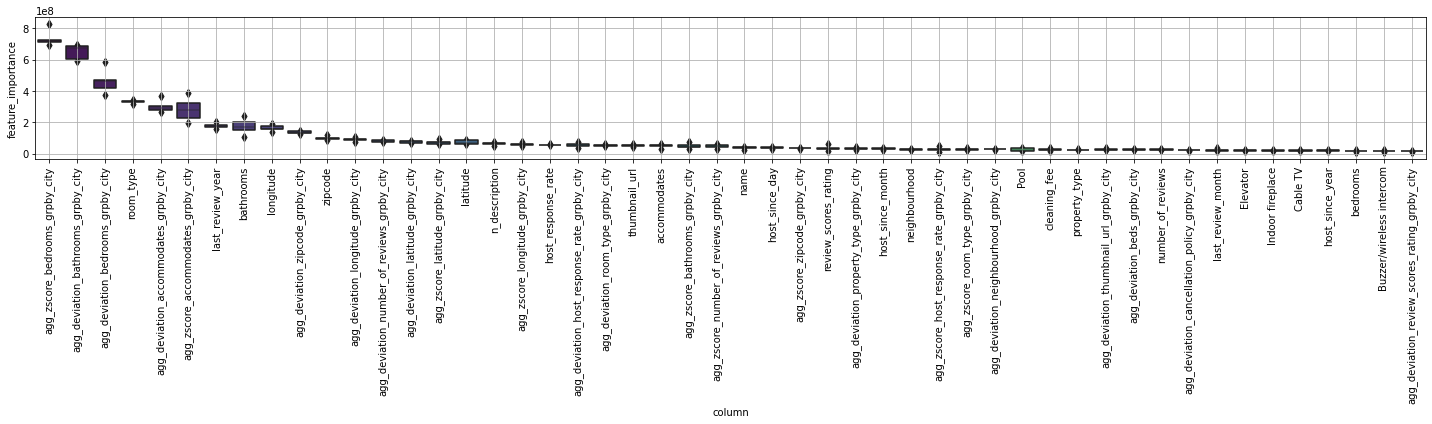

In [193]:
visualize_importance(models)

# submission

In [139]:
y_preds = []
for i in range(len(preds)):
    y_pred = np.mean(preds[i])
    y_preds.append(y_pred)
y_preds = pd.Series(y_preds)
sample_submit['y'] = y_preds
sample_submit.to_csv('../output/sub_nb000.csv', index=False, header=False)